# The K-Nearest Neighbors Algorithm

The **$K$-nearest neighbors algorithm** (or KNN for short) is a simple supervised machine learning algorithm that assumes that similar things exist in close proximity. In other words, similar things are near to each other.
For example, conisder the [iris data set](https://en.wikipedia.org/wiki/Iris_flower_data_set) in by the code in the first code cell below. 

For this notebook we will need the following packages:
 * RDatasets [documentation](https://github.com/JuliaStats/RDatasets.jl)
 * Plots [documentation](http://docs.juliaplots.org/latest/)
 * CSV [documentation](https://juliadata.github.io/CSV.jl/stable/)
 

Also, knowledge of Julia DataFrames will be needed:
 * DataFrames [documentation](https://juliadata.github.io/DataFrames.jl/stable/) 

---

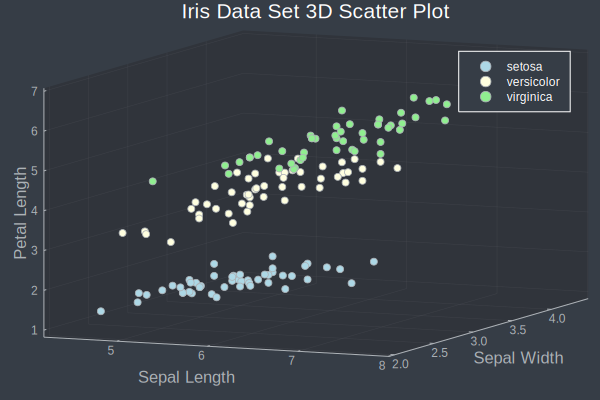

In [1]:
using RDatasets
using Plots
theme(:dark)
using CSV

iris = dataset("datasets", "iris")
X_data = [x for x in zip(iris.SepalLength, iris.SepalWidth, iris.PetalLength)]
Y_data = [iris.Species[i] for i = 1:150]

scatter(xaxis = "Sepal Length",
        yaxis = "Sepal Width", 
        zaxis = "Petal Length",
        title = "Iris Data Set 3D Scatter Plot")

scatter!(X_data[1:50], 
        label = "setosa", 
        color = "lightblue")

scatter!(X_data[51:100], 
        label = "versicolor", 
        color = "lightyellow")

scatter!(X_data[101:150], 
        label = "virginica", 
        color = "lightgreen")

---

In the plot generated by the code cell above (code cell [1]), data points tend to be close to other data points of a similar class (or label). This notion is what the KNN algorithm needs in order to be useful at predicting a given label. Specifically, the KNN algorithm captures the idea of similarity  by calculating the distance between points on a graph.

There are many ways of calculating distance (in the mathematics community these are called metrics), and one way might be preferable to another way depending on the specific problem that we are solving. However, the straight-line distance (also called the Euclidean distance) is a popular and simple choice.

---

In [2]:
# Define the Euclidean distance formula as a function
function euclidean_distance(p1, p2)
    return sqrt(sum([(p1[i] - p2[i])^2 for i = 1:length(p1)]))
end

# Test the function euclidean_distance to make sure it works!
print("The distance between ", X_data[1]," and", X_data[50])
println(" is ", euclidean_distance(X_data[1], X_data[50]));

The distance between (5.1, 3.5, 1.4) and(5.0, 3.3, 1.4) is 0.22360679774997896


------
**The KNN Algorithm**

1. Load the data

2. Initialize $k$ to your chosen number of neighbors

3. For each example in the data

 * Calculate the distance between the query example and the current example from the data.

 * Add the distance and the index of the example to an ordered collection

4. Sort the ordered collection of distances and indices from smallest to largest (in ascending order) by the distances

5. Pick the first $K$ entries from the sorted collection

6. Get the labels of the selected $k$ entries

7. If regression, return the mean of the $K$ labels

8. If classification, return the mode of the $K$ labels


**Advantages**

* The algorithm is simple and easy to implement.
* There’s no need to build a model, tune several parameters, or make additional assumptions.
* The algorithm is versatile. It can be used for classification and regression.

**Disadvantages**

* The algorithm gets significantly slower as the number of examples and/or predictors/independent variables increase.

In the next code cell we write a function that computes the $K$-nearest neighbors to a given point $p$.

---

In [3]:
""" For a given point p, a collection of points X with labels Y, and a positive integer k,
    find the k nearest neighbors to point p.
"""
function k_nearest_neighbors(p, X, Y, k)
    # Calculate the distance between p and all other points in X
    distance_array = [(X[i], Y[i], euclidean_distance(p, X[i])) 
                      for i = 1:length(X)
                      if X[i] != p
                      ]
    # Sort the distance array in ascending order according to distance
    sort!(distance_array, by = x -> x[3])     # Python = distance_array.sort(key = lambda x : x[2])
    
    # Return the first k entries from the sorted distance array 
    return distance_array[1:k]                # Python = distance_array[0:k-1]
end 

# Test the k_nearest_neighbors function
test = k_nearest_neighbors(X_data[120], X_data, Y_data, 5)

println("")
println("Target Point P = ", X_data[120])
println("k = ", 5)
println("____________________________________")
for i = 1:length(test)
    println("Point $i = ", test[i][1])
    println("Point Label = ", test[i][2])
    println("Point Distance = ", test[i][3])
    if i != length(test)
        println("")
    else
      println("____________________________________")  
    end
end
println("")


Target Point P = (6.0, 2.2, 5.0)
k = 5
____________________________________
Point 1 = (5.7, 2.5, 5.0)
Point Label = virginica
Point Distance = 0.4242640687119283

Point 2 = (6.3, 2.5, 5.0)
Point Label = virginica
Point Distance = 0.4242640687119283

Point 3 = (6.3, 2.5, 4.9)
Point Label = versicolor
Point Distance = 0.43588989435406705

Point 4 = (6.0, 2.7, 5.1)
Point Label = versicolor
Point Distance = 0.5099019513592784

Point 5 = (6.2, 2.2, 4.5)
Point Label = versicolor
Point Distance = 0.5385164807134505
____________________________________



--------
**Choosing the right value for $K$**

To select the $K$ that’s right for your data, we run the KNN algorithm several times with different values of $K$. Choose the $K$ that reduces the number of errors we encounter while maintaining the algorithm’s ability to accurately make predictions when it’s given data it hasn’t seen before.

Here are some things to keep in mind:

* As we decrease the value of $K$ to 1, our predictions become less stable. Just think for a minute, imagine $K = 1$ and we have a query point surrounded by several yellos and one green (see the iris plot above generated by code cell [1]), but the green is the single nearest neighbor. Reasonably, we would think the query point is most likely yellow, but because $K = 1$, KNN incorrectly predicts that the query point is green.
    
* Inversely, as we increase the value of $k$, our predictions become more stable due to majority voting / averaging, and thus, more likely to make more accurate predictions (up to a certain point). Eventually, we begin to witness an increasing number of errors. It is at this point we know we have pushed the value of $k$ too far. In cases where we are taking a majority vote (e.g. picking the mode in a classification problem) among labels, we usually make $k$ an odd number to have a tiebreaker.

In the next code cell (code cell [4]), we write a function that both makes a prediction and also allows visualization of taking different values of $K$. 

----

In [4]:
function predict(index::Int64, X, Y, k; point_color = "red", show_img = false)
    
    point = X[index]
    neighbors = k_nearest_neighbors(point, X, Y, k)
    setosa_count = sum([1 for x in neighbors if x[2] == "setosa"])
    versicolor_count = sum([1 for x in neighbors if x[2] == "versicolor"])
    virginica_count = sum([1 for x in neighbors if x[2] == "virginica"])
    
    
    
    if show_img == true
        scatter(xaxis = "Sepal Length",
                yaxis = "Sepal Width", 
                zaxis = "Petal Length",
                title = "Iris Data Set 3D Scatter Plot")
        for x in neighbors
            plot!([point, x[1]], color = point_color, label = false)
        end
    end
    
    
    
    
    if show_img == true
        scatter!(X[1:50], 
                label = "setosa", 
                color = "lightblue")
        scatter!(X[51:100], 
                    label = "versicolor", 
                color = "lightyellow")
        scatter!(X[101:150], 
                label = "virginica", 
                color = "lightgreen")
        scatter!(point, color = point_color, label = "target")
    end

    
    
    println("     P(setosa)       |       P(versicolor)     |     P(virginica)")
    println("------------------------------------------------------------------")
    print("        ", setosa_count // k,"        |             ", versicolor_count//k)
    print("        |        ", virginica_count//k)
    println(" ")
    println()
    
    
    if show_img == true
            scatter!()
    end
end;

     P(setosa)       |       P(versicolor)     |     P(virginica)
------------------------------------------------------------------
        0//1        |             8//13        |        5//13 



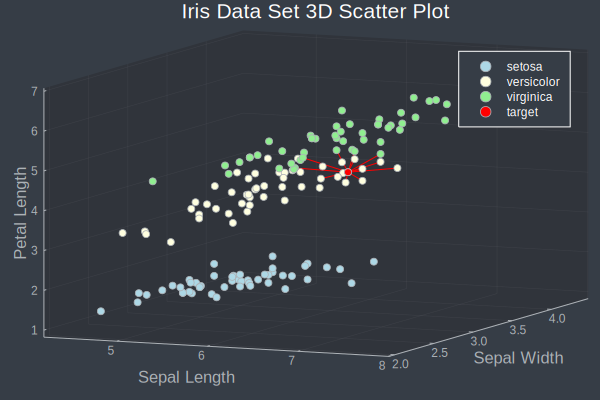

In [5]:
# Test the predict function to make sure it works!
predict(77, X_data, Y_data, 13, show_img = true)


---
**Recommendation Example**

Imagine for a moment. We are navigating the MoviesXb website, a fictional IMDb spin-off, and we encounter The Avengers. We aren’t sure we want to watch it, but its genres intrigue us; we are curious about other similar movies. We scroll down to the “More Like This” section to see what recommendations MoviesXb will make, and the algorithmic gears begin to turn... 

Write a function that provides us with a recommended list of "More Like This" movies using the KNN algorithm.

---

In [6]:
# First read the csv file from your directory
movies = CSV.read("movies_recommendation_data.csv")
X_data = [x for x in zip(movies.IMDBRating, movies.Biography, movies.Drama, movies.Thriller)]
Y_data = [x for x in movies.MovieName];

---

In the next code cell we write a movie recommender function using KNN.

---

In [7]:
function more_like_this(movie_name, X, Y, k)
    
    for i = 1:length(Y)
        if Y[i] == movie_name
            L = k_nearest_neighbors(X[i], X, Y, k)
            println("The top $k similar movies with $movie_name are:")
            for j = 1:k
                println("$j. ", L[j][2])
            end
        end
    end
end;

In [8]:
more_like_this("The Avengers", X_data, Y_data, 5)

The top 5 similar movies with The Avengers are:
1. The Terminator
2. Avatar
3. Thor: Ragnarok
4. Spirited Away
5. Black Panther


---

**Summary**

The $K$-nearest neighbors (KNN) algorithm is a simple, supervised machine learning algorithm that can be used to solve both classification and regression problems. It’s easy to implement and understand, but has a major drawback of becoming significantly slows as the size of that data in use grows.

KNN works by finding the distances between a query and all the examples in the data, selecting the specified number examples ($K$) closest to the query, then votes for the most frequent label (in the case of classification) or averages the labels (in the case of regression).

In the case of classification and regression, we saw that choosing the right $K$ for our data is done by trying several $K$s and picking the one that works best.

---